<a href="https://colab.research.google.com/github/kelonion/neural_network_with_numpy/blob/master/neutal_network_numpy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Multiple Layers Neural Network for MNIST <br> Using NumPy

This document illustrates the processes to train handwriting recognition model using a hand-coded multuple layers neural network on numpy.

In our examples, we are using input_data.py given by the tutorial of TensorFlow to load that dataset. It is quite useful for managing our data, and handle:

- Dataset downloading
- Loading the entire dataset into numpy array

### 1. Imports

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data

### 2. Dataset


In [32]:
# Import MINST data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [0]:
# Load data
X_train = mnist.train.images
Y_train = mnist.train.labels
X_test = mnist.test.images
Y_test = mnist.test.labels

In [4]:
# Shape of the data sets
print("The shape of training set:", "X:",X_train.shape, "Y:", Y_train.shape)
print("The shape of test set:", "X:",X_test.shape, "Y:", Y_test.shape)

The shape of training set: X: (55000, 784) Y: (55000, 10)
The shape of test set: X: (10000, 784) Y: (10000, 10)


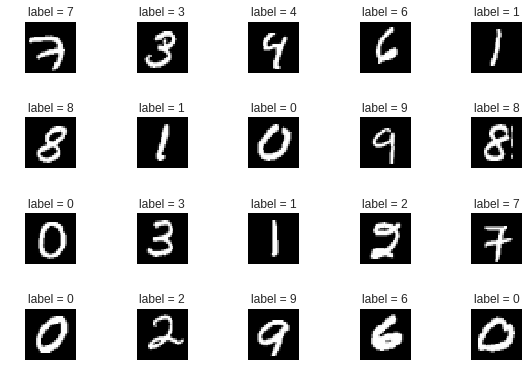

In [5]:
# Visualize the training data (the first 20 groups of data)
ROW = 4
COLUMN = 5
for i in range(ROW * COLUMN):
    image = np.reshape(X_train[i], (28, 28))  
    plt.subplot(ROW, COLUMN, i+1)          # subplot with size (width 3, height 5)
    plt.imshow(image, cmap='gray')  # cmap='gray' is for black and white picture.
    plt.title('label = {}'.format(int(np.argmax(Y_train[i]))))
    plt.axis('off')  
plt.tight_layout()
plt.show()

### 3. Neutral network functions

#### 3.1 Parameters initialization


In [0]:
# Create a dict of parameters according to the layer structure
def initialize_parameters(layer_dims):
  parameters = {}
  num_layers = len(layer_dims)
  
  for l in range(num_layers-1):
    parameters['W' + str(l+1)] = np.random.randn(layer_dims[l],layer_dims[l+1]) * 0.01
    parameters['b' + str(l+1)] = np.zeros((1, layer_dims[l+1]))
   
  return parameters

#### 3.2 Forward propagation

In [0]:
# Define sigmoid function
def sigmoid(Z):
  A = 1 / (1 + np.exp(-Z))
  cache = Z
  
  return A, cache

In [0]:
# Define relu function
def relu(Z):
  A = np.maximum(0, Z)
  cache = Z

  return A, cache

In [0]:
# Define linear function to compute Z
def linear_forward(A, W, b):
  Z = np.dot(A, W) + b
  cache = (A, W, b)

  return Z, cache

In [0]:
# Linear activation computation
# Combine the calculation processes in one subgle layer
def linear_activation(A, W, b, method="relu"):
  
  if method  == "relu":
    Z, cache_a = linear_forward(A, W, b)
    A, cache_z = relu(Z)
    
  elif method == "sigmoid":
    Z, cache_a = linear_forward(A, W, b)
    A, cache_z = sigmoid(Z)
    
  act_cache = (cache_a, cache_z)
  
  return A, act_cache

In [0]:
# Forward propagation
def forward_prop(X, parameters):
  num_layers = len(parameters) // 2
  A_prev = X
  caches = []
  
  # Loop over the layers using "relu"
  for l in range(num_layers-1):
    W = parameters['W' + str(l+1)]
    b = parameters['b' + str(l+1)]
    A, act_cache = linear_activation(A_prev, W, b, method="relu")
    caches.append(act_cache)
    A_prev = A
  
  # Compute the last layer separately using "sigmoid"
  W = parameters['W' + str(num_layers)]
  b = parameters['b' + str(num_layers)]
  
  A, act_cache = linear_activation(A_prev, W, b, method="sigmoid")
  caches.append(act_cache)
  
  return  A, caches
  

#### 3.3 Cost function


In [0]:
def compute_cost(A, Y):

  cost = - np.mean(np.multiply(Y, np.log(A)) + np.multiply(1-Y, np.log(1-A)))
  
  return cost

#### 3.4 Backward propagation

In [0]:
def sigmoid_back(dA, cache_z):
  Z = cache_z
  a = 1 / (1 + np.exp(-Z))
  dZ = dA * a * (1-a)

  return dZ

In [0]:
def relu_back(dA, cache_z):
  Z = cache_z
  dZ = np.array(dA, copy=True)
  
  dZ[Z <= 0] = 0
  
  return dZ

In [0]:
def linear_back(dZ, cache):
  A_prev, W, b = cache
  m = A_prev.shape[0]

  dW = 1/m * np.dot(A_prev.T, dZ)
  db = 1/m * np.sum(dZ, axis=0, keepdims=True)
  dA_prev = np.dot(dZ, W.T)
  
  assert (dA_prev.shape == A_prev.shape)
  assert (dW.shape == W.shape)
  assert (db.shape == b.shape)  
  
  return dA_prev, dW, db

In [0]:
def linear_activation_back(dA, cache, method="relu"):
  cache_a, cache_z = cache
  
  if method == "relu":
    dZ = relu_back(dA, cache_z)
    dA_prev, dW, db = linear_back(dZ, cache_a)
    
  elif method == "sigmoid":
    dZ = sigmoid_back(dA, cache_z)
    dA_prev, dW, db = linear_back(dZ, cache_a)
    
  return dA_prev, dW, db

In [0]:
def back_prop(AL, Y, caches):
  grads = {}
  L = len(caches)
  m = Y.shape[0]
  
  # Compute dA in the last layer individually
  dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
  current_cache = caches[-1]
  grads["dA"+str(L-1)], grads["dW"+str(L)], grads["db"+str(L)] = linear_activation_back(dAL, current_cache, method="sigmoid")
  
  # Loop over the rest layers to compute dA, dW & db
  for l in reversed(range(L-1)):
    current_cache = caches[l]
    dA = grads["dA"+str(l+1)]
    grads["dA"+str(l)], grads["dW"+str(l+1)], grads["db"+str(l+1)] = linear_activation_back(dA, current_cache, method="relu")
  
  return grads

#### 3.5 Update parameters

In [0]:
def update_parameters(parameters, grads, learning_rate):
  L = len(parameters) // 2
  
  for l in range(L):
    parameters["W"+str(l+1)] = parameters["W"+str(l+1)] - learning_rate * grads["dW"+str(l+1)]
    parameters["b"+str(l+1)] = parameters["b"+str(l+1)] - learning_rate * grads["db"+str(l+1)]
    
  return parameters

#### 3.6 Prediction

In [0]:
def predict(X, Y, parameters):
  AL, _ = forward_prop(X, parameters)
  result = np.equal(np.argmax(AL, axis=1), np.argmax(Y, axis=1))
  accuracy = np.mean(result)
  
  return accuracy

### 4. Training model

In [0]:
# Define hyperparameters for the model
layer_dims = [784, 25, 15, 10]
learning_rate = 0.005
epochs = 100
batch_size = 32

In [0]:
# Training function
def nn_training(layer_dims, learning_rate, epochs, batch_size):
  
  # Initialize parameters
  parameters = initialize_parameters(layer_dims)
  
  for epoch in range(epochs):
    avg_cost = 0
    batches = int(X_train.shape[0] / batch_size)
    
    # Loop over batches
    for batch in range(batches + 1):
      
      # Using build-in function to divide the data into batches
      x_train, y_train = mnist.train.next_batch(batch_size)
      
      AL, caches = forward_prop(x_train, parameters)
      
      cost = compute_cost(AL, y_train)
      avg_cost += cost / batches
      
      grads = back_prop(AL, y_train, caches)
      
      parameters = update_parameters(parameters, grads, learning_rate)
    
    if epoch % 10 == 0:
      print("Epoch:", epoch, "cost:", avg_cost)
      
  return parameters

In [22]:
para = nn_training(layer_dims, learning_rate, epochs, batch_size)

Epoch: 0 cost: 0.4153491939049328
Epoch: 10 cost: 0.11549562178445279
Epoch: 20 cost: 0.05061367918074255
Epoch: 30 cost: 0.034600400886857986
Epoch: 40 cost: 0.027763633737991178
Epoch: 50 cost: 0.023851042022501115
Epoch: 60 cost: 0.021142048084047006
Epoch: 70 cost: 0.01927486281711208
Epoch: 80 cost: 0.017818371135846795
Epoch: 90 cost: 0.01648641837814229


In [23]:
print("Accuracy on test set:", predict(X_test, Y_test, para) * 100, "%")

Accuracy on test set: 96.56 %


So we obtain a pretty high accuracy with a simple hand-code neural network using numpy. 

### 5. Performance checking

Index: 9295
Model prediction is 1
The answer is 1


(-0.5, 27.5, 27.5, -0.5)

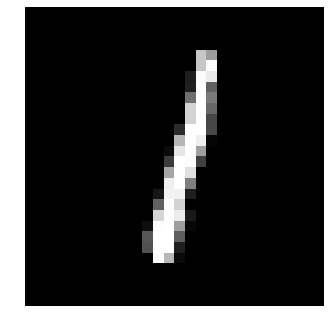

In [30]:
# Select data from test set
index = int(np.random.rand()*10000)

# Check whether the prediction matches
image = np.reshape(X_test[index], (28, 28))
AL, _ = forward_prop(X_test[index], para)
pred = int(np.argmax(AL, axis=1))
print("Index:", index)
print("Model prediction is", pred)
print("The answer is", int(np.argmax(Y_test[index])))

# Plot the image
plt.imshow(image, cmap='gray')
plt.axis('off')


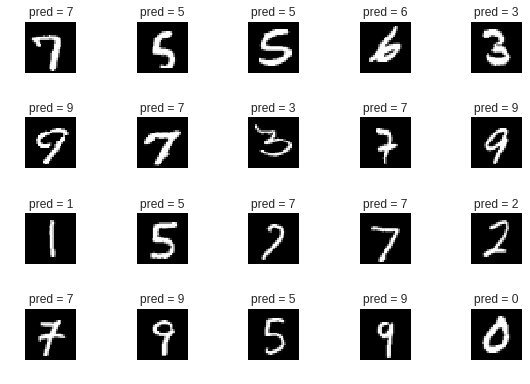

In [31]:
# Check for the performance on more examples
ROW = 4
COLUMN = 5
random_arr = np.arange(10000)
np.random.shuffle(random_arr)      # Shuffle the test set

# Plot the results
for i in range(ROW * COLUMN):
    index = random_arr[i]
    image = np.reshape(X_test[index], (28, 28))  
    AL, _ = forward_prop(X_test[index], para)
    pred = int(np.argmax(AL, axis=1))
    plt.subplot(ROW, COLUMN, i+1)
    plt.imshow(image, cmap='gray')
    plt.title('pred = {}'.format(int(np.argmax(AL, axis=1))))
    plt.axis('off')  
plt.tight_layout()
plt.show()

### Notation
This example shows a fundamental application of neural network. There are several techniques had not been included such as hyperparameter tunning, model optimization etc. However, readers with basic knowledge about Deep Learning can easily gain an intuition of how multi-layer neural network works through this example.